In [ ]:
import pandas as pd

# Load datasets
enrollment_df = pd.read_csv("enrollment.csv")
demographic_df = pd.read_csv("demographic.csv")
biometric_df = pd.read_csv("biometric.csv")

# Clean column names (extra spaces हटाने के लिए)
enrollment_df.columns = enrollment_df.columns.str.strip()
demographic_df.columns = demographic_df.columns.str.strip()
biometric_df.columns = biometric_df.columns.str.strip()

# Reset index to align rows
enrollment_df.reset_index(drop=True, inplace=True)
demographic_df.reset_index(drop=True, inplace=True)
biometric_df.reset_index(drop=True, inplace=True)

# Merge all datasets column-wise
final_df = pd.concat(
    [enrollment_df, demographic_df, biometric_df],
    axis=1
)
final_df.to_csv("final_merged_dataset.csv", index=False)

In [5]:
Enroll_0_5  = "age_0_5"
Enroll_5_17 = "age_5_17"
Enroll_18p  = "age_18_greater"

Demo_5_17   = "demo_age_5_17"
Demo_18p    = "demo_age_17_"

Bio_5_17    = "bio_age_5_17"
Bio_18p     = "bio_age_17_"


In [6]:
final_df["Biometric_Risk_Score"] = (
    final_df[Bio_5_17] * 0.3 +
    final_df[Bio_18p] * 0.7
)

final_df["Demographic_Risk_Score"] = (
    final_df[Demo_5_17] * 0.4 +
    final_df[Demo_18p] * 0.6
)

final_df["Enrollment_Risk_Score"] = (
    final_df[Enroll_0_5] * 0.2 +
    final_df[Enroll_5_17] * 0.3 +
    final_df[Enroll_18p] * 0.5
)

final_df["Total_Risk_Score"] = (
    final_df["Biometric_Risk_Score"] +
    final_df["Demographic_Risk_Score"] +
    final_df["Enrollment_Risk_Score"]
)

print(" RISK SCORE GENERATED")
print(final_df[[
    "state", "district", "pincode", "Total_Risk_Score"
]].head())


 RISK SCORE GENERATED
           state           state state          district    district  \
0      Meghalaya   Uttar Pradesh   Goa  East Khasi Hills   Gorakhpur   
1      Karnataka  Andhra Pradesh   Goa   Bengaluru Urban    Chittoor   
2  Uttar Pradesh         Gujarat   Goa      Kanpur Nagar      Rajkot   
3  Uttar Pradesh  Andhra Pradesh   Goa           Aligarh  Srikakulam   
4      Karnataka       Rajasthan   Goa   Bengaluru Urban     Udaipur   

    district   pincode  pincode   pincode  Total_Risk_Score  
0  North Goa  793121.0   273213  403502.0             378.8  
1  North Goa  560043.0   517132  403508.0             269.1  
2  North Goa  208001.0   360006  403513.0             522.0  
3  North Goa  202133.0   532484  403527.0             228.6  
4  South Goa  560016.0   313801  403601.0             511.3  


In [7]:
def a2sv_decision(score):
    if score > 2000:
        return "MANDATORY_2SV"
    elif score > 1000:
        return "OPTIONAL_2SV"
    else:
        return "NORMAL_AUTH"

final_df["Aadhaar_2SV_Mode"] = final_df["Total_Risk_Score"].apply(a2sv_decision)


In [8]:
import numpy as np
transactions_df = pd.DataFrame({
    "transaction_id": range(1, len(final_df)+1),
    "purpose": "AEPS_WITHDRAWAL",
    "amount": np.random.randint(500, 20000, size=len(final_df)),
    "status": "PENDING",
    "request_time": pd.Timestamp.now()
})


In [9]:
def aadhaar_2sv_decision(response):
    if response == "YES":
        return "APPROVED"
    elif response == "NO":
        return "BLOCKED"
    else:
        return "BLOCKED"  # Default safety


In [10]:
transactions_df["user_response"] = np.random.choice(
    ["YES", "NO", None],
    size=len(transactions_df),
    p=[0.6, 0.2, 0.2]
)

transactions_df["final_status"] = transactions_df["user_response"].apply(
    aadhaar_2sv_decision
)


In [11]:
final_df["Aadhaar_Locked"] = transactions_df["final_status"] == "BLOCKED"


In [12]:
final_df["Fraud_Flag"] = (
    (transactions_df["final_status"] == "BLOCKED") &
    (final_df["Total_Risk_Score"] > 1500)
)


In [13]:
def generate_alert(row):
    return f"""
    Aadhaar Alert:
    Purpose: AEPS Withdrawal
    Amount: ₹{row['amount']}
    Action Required: YES / NO
    """

transactions_df["alert_message"] = transactions_df.apply(generate_alert, axis=1)


In [14]:
def alert_channel(row):
    if row[Enroll_18p] < (row[Enroll_0_5] + row[Enroll_5_17]):
        return "SMS + IVR"
    else:
        return "APP + SMS"

final_df["Alert_Channel"] = final_df.apply(alert_channel, axis=1)


In [15]:
output_df = final_df[[
    "date", "state", "district", "pincode",
    "Total_Risk_Score",
    "Aadhaar_2SV_Mode",
    "Alert_Channel"
]]

output_df.to_csv("aadhaar_a2sv_final_output.csv", index=False)

print(" FINAL AADHAAR A-2SV SYSTEM OUTPUT SAVED")
print(output_df.head())


 FINAL AADHAAR A-2SV SYSTEM OUTPUT SAVED
         date        date        date          state           state state  \
0  02-03-2025  01-03-2025  19-09-2025      Meghalaya   Uttar Pradesh   Goa   
1  09-03-2025  01-03-2025  19-09-2025      Karnataka  Andhra Pradesh   Goa   
2  09-03-2025  01-03-2025  19-09-2025  Uttar Pradesh         Gujarat   Goa   
3  09-03-2025  01-03-2025  19-09-2025  Uttar Pradesh  Andhra Pradesh   Goa   
4  09-03-2025  01-03-2025  19-09-2025      Karnataka       Rajasthan   Goa   

           district    district   district   pincode  pincode   pincode  \
0  East Khasi Hills   Gorakhpur  North Goa  793121.0   273213  403502.0   
1   Bengaluru Urban    Chittoor  North Goa  560043.0   517132  403508.0   
2      Kanpur Nagar      Rajkot  North Goa  208001.0   360006  403513.0   
3           Aligarh  Srikakulam  North Goa  202133.0   532484  403527.0   
4   Bengaluru Urban     Udaipur  South Goa  560016.0   313801  403601.0   

   Total_Risk_Score Aadhaar_2SV_Mode Al

In [16]:
import matplotlib.pyplot as plt

# Duplicate columns हटाकर first state रखें
final_df = final_df.loc[:, ~final_df.columns.duplicated()]


In [17]:
import numpy as np
from datetime import datetime, timedelta

transactions_df = pd.DataFrame({
    "transaction_id": range(1, len(final_df) + 1),
    "aadhaar_use_type": np.random.choice(
        ["AEPS_WITHDRAWAL", "eKYC", "SIM_VERIFICATION"],
        size=len(final_df)
    ),
    "amount": np.random.randint(500, 20000, size=len(final_df)),
    "status": "PENDING",
    "request_time": datetime.now(),
    "expiry_time": datetime.now() + timedelta(minutes=15)
})

transactions_df.head()


,transaction_id,aadhaar_use_type,amount,status,request_time,expiry_time
0,1,eKYC,13916,PENDING,2026-01-20 15:35:46.495158,2026-01-20 15:50:46.495166
1,2,eKYC,12015,PENDING,2026-01-20 15:35:46.495158,2026-01-20 15:50:46.495166
2,3,eKYC,5311,PENDING,2026-01-20 15:35:46.495158,2026-01-20 15:50:46.495166
3,4,SIM_VERIFICATION,14691,PENDING,2026-01-20 15:35:46.495158,2026-01-20 15:50:46.495166
4,5,SIM_VERIFICATION,3303,PENDING,2026-01-20 15:35:46.495158,2026-01-20 15:50:46.495166


In [18]:
# State-wise total risk
state_risk = (
    final_df
    .groupby("state")["Total_Risk_Score"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)


In [19]:
def generate_alert(row):
    return f"""
Aadhaar Alert!
Purpose: {row['aadhaar_use_type']}
Amount: ₹{row['amount']}
Action Required:
Reply YES to allow
Reply NO to block
"""

transactions_df["alert_message"] = transactions_df.apply(
    generate_alert, axis=1
)

transactions_df[["transaction_id", "alert_message"]].head()


,transaction_id,alert_message
0,1,\nAadhaar Alert!\nPurpose: eKYC\nAmount: ₹1391...
1,2,\nAadhaar Alert!\nPurpose: eKYC\nAmount: ₹1201...
2,3,\nAadhaar Alert!\nPurpose: eKYC\nAmount: ₹5311...
3,4,\nAadhaar Alert!\nPurpose: SIM_VERIFICATION\nA...
4,5,\nAadhaar Alert!\nPurpose: SIM_VERIFICATION\nA...


In [20]:
transactions_df["user_response"] = np.random.choice(
    ["YES", "NO", None],
    size=len(transactions_df),
    p=[0.6, 0.2, 0.2]  # 20% no response
)

transactions_df[["transaction_id", "user_response"]].head()


,transaction_id,user_response
0,1,YES
1,2,YES
2,3,None
3,4,YES
4,5,YES


In [21]:
def aadhaar_2sv_engine(row):
    current_time = datetime.now()

    if row["user_response"] == "YES":
        return "APPROVED"

    if row["user_response"] == "NO":
        return "BLOCKED"

    if current_time > row["expiry_time"]:
        return "BLOCKED"  # Default safety

    return "BLOCKED"


In [22]:
transactions_df["final_status"] = transactions_df.apply(
    aadhaar_2sv_engine, axis=1
)

transactions_df[["transaction_id", "final_status"]].head()


,transaction_id,final_status
0,1,APPROVED
1,2,APPROVED
2,3,BLOCKED
3,4,APPROVED
4,5,APPROVED


In [23]:
final_df["Aadhaar_Locked"] = transactions_df["final_status"] == "BLOCKED"

final_df[["Aadhaar_Locked"]].value_counts()


Aadhaar_Locked
False             1243820
True               827880
Name: count, dtype: int64

In [24]:
final_df["Fraud_Flag"] = (
    (transactions_df["final_status"] == "BLOCKED") &
    (final_df["Total_Risk_Score"] > 1500)
)

final_df[["Fraud_Flag"]].value_counts()


Fraud_Flag
False         2071430
True              270
Name: count, dtype: int64

In [25]:
a2sv_final_output = pd.concat(
    [final_df, transactions_df],
    axis=1
)

a2sv_final_output = a2sv_final_output[[
    "state", "district", "pincode",
    "aadhaar_use_type", "amount",
    "user_response", "final_status",
    "Aadhaar_Locked", "Fraud_Flag"
]]

a2sv_final_output.to_csv(
    "aadhaar_a2sv_transaction_output.csv",
    index=False
)

a2sv_final_output.head()


,state,district,pincode,aadhaar_use_type,amount,user_response,final_status,Aadhaar_Locked,Fraud_Flag
0,Meghalaya,East Khasi Hills,793121.0,eKYC,13916,YES,APPROVED,False,False
1,Karnataka,Bengaluru Urban,560043.0,eKYC,12015,YES,APPROVED,False,False
2,Uttar Pradesh,Kanpur Nagar,208001.0,eKYC,5311,None,BLOCKED,True,False
3,Uttar Pradesh,Aligarh,202133.0,SIM_VERIFICATION,14691,YES,APPROVED,False,False
4,Karnataka,Bengaluru Urban,560016.0,SIM_VERIFICATION,3303,YES,APPROVED,False,False


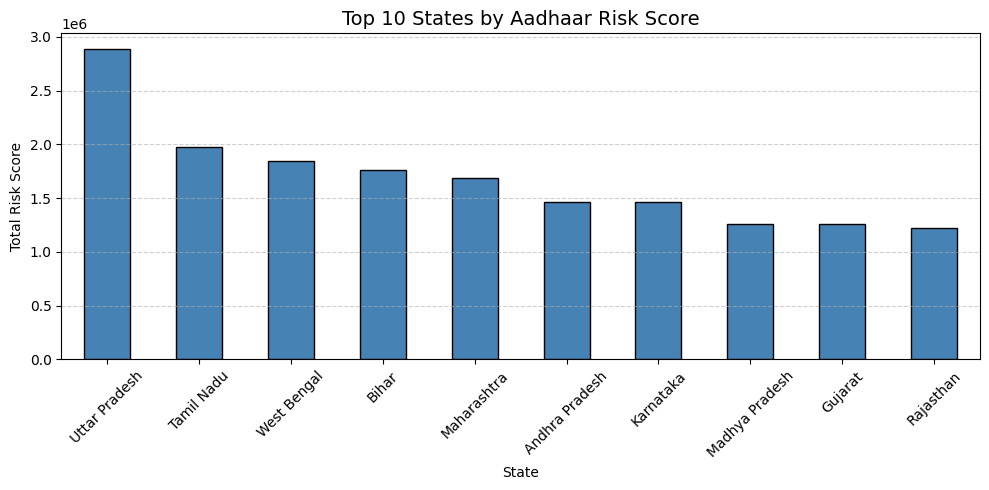

In [31]:
plt.figure(figsize=(10,5))

state_risk.plot(
    kind="bar",
    color="steelblue",
    edgecolor="black"
)

plt.title("Top 10 States by Aadhaar Risk Score", fontsize=14)
plt.xlabel("State")
plt.ylabel("Total Risk Score")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


In [32]:
# Safety: duplicate columns हटाओ
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

# Top 10 fraud-prone states (High Risk)
fraud_states = (
    final_df.groupby("state")["Total_Risk_Score"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

print(fraud_states)   # check (optional)


state
Uttar Pradesh     2887444.0
Tamil Nadu        1977207.9
West Bengal       1844006.8
Bihar             1757439.9
Maharashtra       1687407.9
Andhra Pradesh    1466825.3
Karnataka         1463234.3
Madhya Pradesh    1261483.0
Gujarat           1256789.6
Rajasthan         1223982.7
Name: Total_Risk_Score, dtype: float64


In [33]:
# Duplicate columns हटाएँ
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

# Alert channel logic
def alert_channel(row):
    if row["age_18_greater"] < (row["age_0_5"] + row["age_5_17"]):
        return "SMS + IVR (Rural)"
    else:
        return "APP + SMS (Urban)"

final_df["Alert_Channel"] = final_df.apply(alert_channel, axis=1)

print(final_df["Alert_Channel"].value_counts())


Alert_Channel
APP + SMS (Urban)    1080392
SMS + IVR (Rural)     991308
Name: count, dtype: int64


In [ ]:
# Top 15 fraud-prone states
top15_states = (
    final_df.groupby("state")["Total_Risk_Score"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .index
)



<Figure size 1200x600 with 0 Axes>

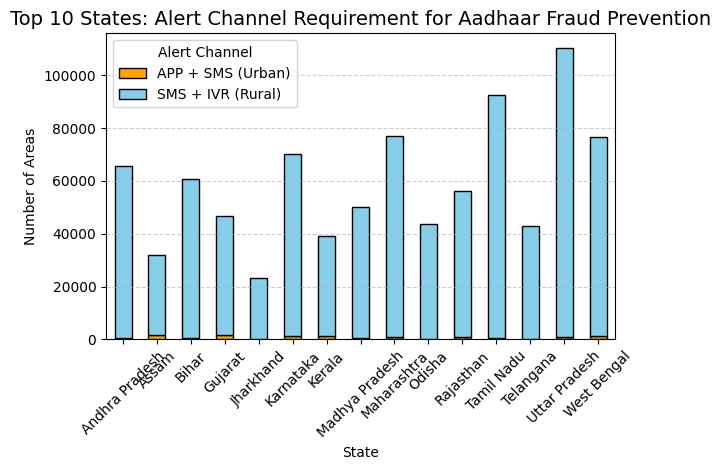

In [35]:
import matplotlib.pyplot as plt

# State-wise alert channel count (Top-15 only)
top10_state_alert = (
    final_df[final_df["state"].isin(top15_states)]
    .groupby(["state", "Alert_Channel"])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12,6))

top10_state_alert.plot(
    kind="bar",
    stacked=True,
    color=["orange", "skyblue"],
    edgecolor="black"
)

plt.title("Top 10 States: Alert Channel Requirement for Aadhaar Fraud Prevention", fontsize=14)
plt.xlabel("State")
plt.ylabel("Number of Areas")
plt.xticks(rotation=45)
plt.legend(title="Alert Channel")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [36]:
import pandas as pd

# Example dataframe
final_df = pd.read_csv("biometric.csv")
final_df=pd.read_csv("demographic.csv")
final_df=pd.read_csv("enrollment.csv") # ya jo bhi source ho


In [38]:
final_df["Total_Risk_Score"] = (
    final_df["age_0_5"] * 3 +
    final_df["age_5_17"] * 2 +
    final_df["age_18_greater"] * 1
)


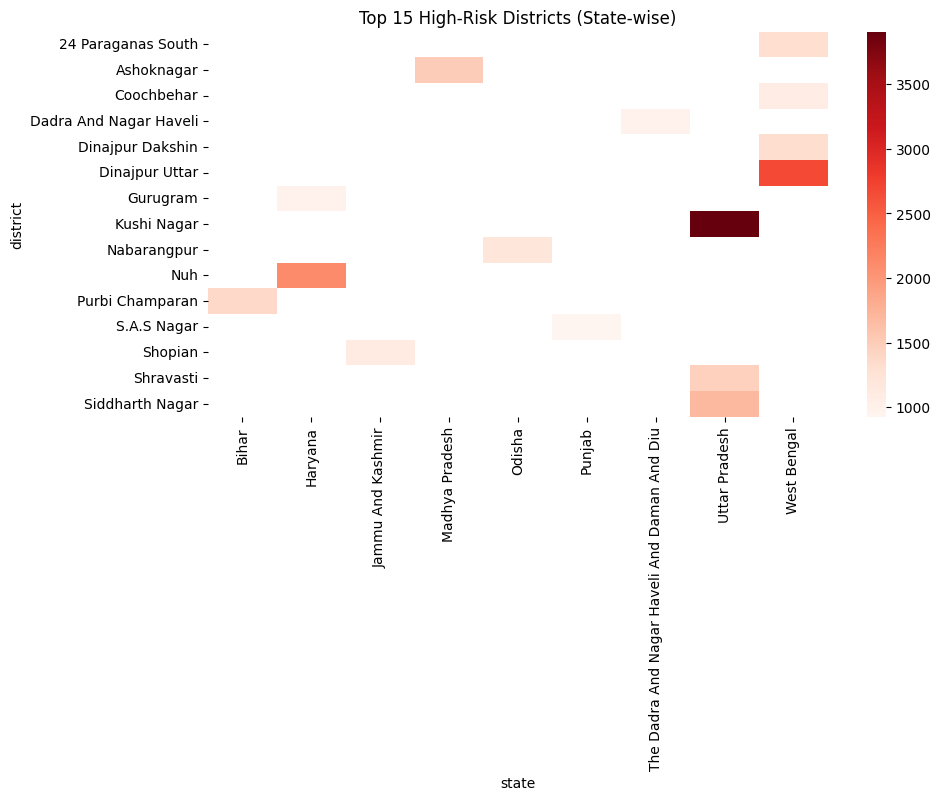

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

top_districts = (
    final_df.groupby("district")["Total_Risk_Score"]
    .mean()
    .sort_values(ascending=False)
    .head(15)
    .index
)

pivot_small = final_df[final_df["district"].isin(top_districts)].pivot_table(
    values="Total_Risk_Score",
    index="district",
    columns="state",
    aggfunc="mean"
)

plt.figure(figsize=(10,5))
sns.heatmap(pivot_small, cmap="Reds")
plt.title("Top 15 High-Risk Districts (State-wise)")
plt.show()
